### **Load Libraries**

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow_hub as hub
import time

# Data augmentation and model preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, Reshape, multiply, add, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import DepthwiseConv2D, BatchNormalization, Activation, ZeroPadding2D
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, BatchNormalization,
                                     ReLU, GlobalAveragePooling2D, Reshape, Dense, multiply, Add)
from tensorflow.keras.models import Model

### **Define Paths & Load Data**

In [ ]:
# NIH Dataset paths
BASE_PATH = "/content/drive/MyDrive/NIH_processed"
TRAIN_PATH = "/content/drive/MyDrive/NIH_processed/train"
TEST_PATH = "/content/drive/MyDrive/NIH_processed/test"

labels = ['pneumonia', 'normal']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train = get_data(TRAIN_PATH)
test = get_data(TEST_PATH)

print(train.head(5))
print(f"\nThe shape of The Train data is: {train.shape}")
print(f"The shape of The Test data is: {test.shape}")

                                            filepath      label
0  /content/drive/MyDrive/NIH_processed/train/pne...  pneumonia
1  /content/drive/MyDrive/NIH_processed/train/pne...  pneumonia
2  /content/drive/MyDrive/NIH_processed/train/pne...  pneumonia
3  /content/drive/MyDrive/NIH_processed/train/pne...  pneumonia
4  /content/drive/MyDrive/NIH_processed/train/pne...  pneumonia

The shape of The Train data is: (5320, 2)
The shape of The Test data is: (1784, 2)


In [ ]:
# Check class imbalance
def check_class_imbalance(directory):
    """Check class distribution in the dataset"""
    print(f"Checking class distribution in: {directory}")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {class_name}: {count} images")
    print()

print("NIH Dataset Class Distribution:")
check_class_imbalance(TRAIN_PATH)
check_class_imbalance(TEST_PATH)

NIH Dataset Class Distribution:
Checking class distribution in: /content/drive/MyDrive/NIH_processed/train
  normal: 4069 images
  pneumonia: 1251 images

Checking class distribution in: /content/drive/MyDrive/NIH_processed/test
  normal: 1272 images
  pneumonia: 512 images



In [ ]:
# Create datasets
IMAGE_SIZE = (224, 224)

print('\nTraining Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nValidation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nTesting Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Get class names
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names


class_labels =['pneumonia', 'normal']
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

# Normalize pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))


Training Images:
Found 5320 files belonging to 2 classes.
Using 4256 files for training.

Validation Images:
Found 5320 files belonging to 2 classes.
Using 1064 files for validation.

Testing Images:
Found 1784 files belonging to 2 classes.


In [ ]:
# Count files
def retrieveNumberOfFiles(path):
    return len([f for f in os.listdir(os.path.join(path, "normal")) if f.endswith(('png', 'jpg', 'jpeg'))] +
               [f for f in os.listdir(os.path.join(path, "pneumonia")) if f.endswith(('png', 'jpg', 'jpeg'))])

totalTrain = retrieveNumberOfFiles(TRAIN_PATH)
totalTest = retrieveNumberOfFiles(TEST_PATH)

# Get class weights
allTrainFiles = [os.path.join(TRAIN_PATH, "normal", f) for f in os.listdir(os.path.join(TRAIN_PATH, "normal"))] + \
                [os.path.join(TRAIN_PATH, "pneumonia", f) for f in os.listdir(os.path.join(TRAIN_PATH, "pneumonia"))]

trainLabels = [0 if "normal" in p else 1 for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = {i: classTotals.max() / classTotals[i] for i in range(len(classTotals))}

# Data generators
BATCH_SIZE = 32
INIT_LR = 1e-4
EPOCHS = 20

trainAug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

valAug = ImageDataGenerator(preprocessing_function=preprocess_input)

trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)

validationGen = valAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 5320 images belonging to 2 classes.
Found 5320 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.


#### **Build Model with SE Block**

In [ ]:
# Implement Squeeze and Excitation block
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

# Build SE-MobileNetV2 model (SE integration)
def se_mobilenet_v2(input_shape=(224, 224, 3), alpha=1.0, include_top=True, weights='imagenet', classes=1000, ratio=16):
    base_model = MobileNetV2(input_shape=input_shape, alpha=alpha, include_top=False, weights=weights)

    x = base_model.output

    # Add SE blocks after layers with sufficient channels
    se_added = False
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
             if layer.output.shape[-1] is not None and layer.output.shape[-1] > ratio:
                x = squeeze_excite_block(layer.output, ratio=ratio)
                se_added = True

    if not se_added:
        # Add SE block after base model output if no suitable layers were found
        if x.shape[-1] is not None and x.shape[-1] > ratio:
          x = squeeze_excite_block(x, ratio=ratio)
        else:
            print("Not enough channels to add SE block.")


    if include_top:
        # Global pooling and classification
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(classes, activation='softmax')(x)


    model = Model(inputs=base_model.input, outputs=x)

    # Freeze initial layers of the base model (optional)
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Model architecture
CLASSES = ["normal","pneumonia"]
model = se_mobilenet_v2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', ratio=16)

headModel = model.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(256, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation='softmax')(headModel)

model = Model(inputs=model.input, outputs=headModel)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,786,114 (10.63 MB)

 Trainable params: 533,250 (2.03 MB)

 Non-trainable params: 2,252,864 (8.59 MB)

#### **Compile & Train Model**

In [ ]:
# Compile model
print("Compiling model")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Callbacks
os.makedirs("/content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-MobileNetV2", exist_ok=True)
MCName = os.path.sep.join(["/content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-MobileNetV2", "se_mobilenetv2_weights-{epoch:03d}-{val_loss:.4f}.keras"])
checkpoint = ModelCheckpoint(
    MCName,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)
callbacks = [checkpoint]

# Train model
print("Model Fitting")
start_time = time.time()

history = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=validationGen,
    validation_steps=totalTrain // (10 * BATCH_SIZE),
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=EPOCHS)

training_time = (time.time() - start_time) / 60
print(f"\nTraining completed in {training_time:.2f} minutes")

Compiling model
Model Fitting
Epoch 1/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5939 - loss: 1.0367
Epoch 1: val_loss improved from inf to 0.51322, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-MobileNetV2/se_mobilenetv2_weights-001-0.5132.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 1493s 9s/step - accuracy: 0.5942 - loss: 1.0363 - val_accuracy: 0.7695 - val_loss: 0.5132
Epoch 2/25
  1/166 ━━━━━━━━━━━━━━━━━━━━ 3:38 1s/step - accuracy: 0.6562 - loss: 1.3418

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.51322
166/166 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.6562 - loss: 1.3418 - val_accuracy: 0.7559 - val_loss: 0.5305
Epoch 3/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6799 - loss: 0.9350
Epoch 3: val_loss did not improve from 0.51322
166/166 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.6799 - loss: 0.9350 - val_accuracy: 0.7246 - val_loss: 0.5874
Epoch 4/25
  1/166 ━━━━━━━━━━━━━━━━━━━━ 3:14 1s/step - accuracy: 0.5312 - loss: 1.2303
Epoch 4: val_loss did not improve from 0.51322
166/166 ━━━━━━━━━━━━━━━━━━━━ 34s 199ms/step - accuracy: 0.5312 - loss: 1.2303 - val_accuracy: 0.7227 - val_loss: 0.5923
Epoch 5/25
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6627 - loss: 0.9522
Epoch 5: val_loss did not improve from 0.51322
166/166 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6629 - loss: 0.9520 - val_accuracy: 0.7559 - val_loss: 0.5380
Epoch 6/25
  1/166 ━━━━━━━━━━━━━━━━━━━━ 2:58 1s/step - accuracy: 0.7188 - loss

### **Evaluate  Model**


Evaluating model...
56/56 ━━━━━━━━━━━━━━━━━━━━ 485s 9s/step - accuracy: 0.7797 - loss: 0.5123
Test Accuracy: 74.38%
Test Loss: 0.5434
56/56 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.8433    0.7869    0.8142      1272
   pneumonia     0.5461    0.6367    0.5879       512

    accuracy                         0.7438      1784
   macro avg     0.6947    0.7118    0.7010      1784
weighted avg     0.7580    0.7438    0.7492      1784


Confusion Matrix:
[[1001  271]
 [ 186  326]]
Accuracy: 0.7438
Sensitivity: 0.6367
Specificity: 0.7869


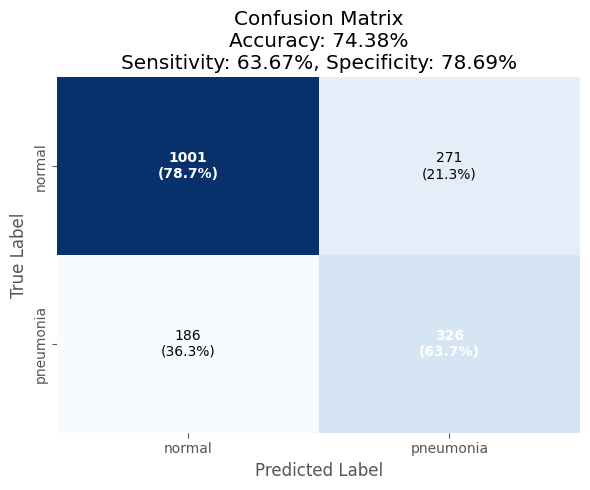

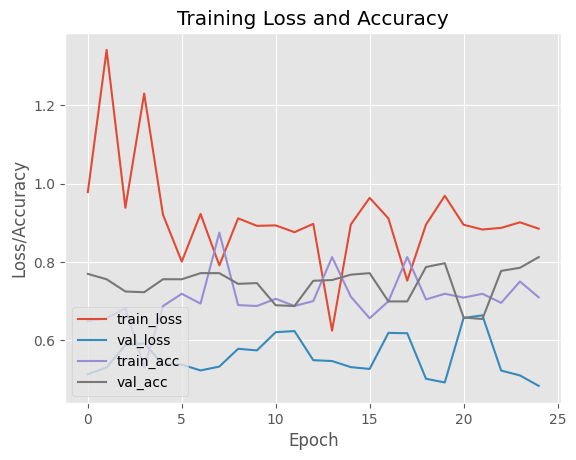

In [ ]:
# Evaluate model
print("\nEvaluating model...")
test_results = model.evaluate(testGen, batch_size=BATCH_SIZE)
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Loss: {:.4f}".format(test_results[0]))

# Predictions and classification report
predIdxs = model.predict(testGen)
predTest = np.argmax(predIdxs, axis=1)

print("\nClassification Report:")
print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys(), digits=4))

# Confusion matrix
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
# Calculate Sensitivity and Specificity
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("\nConfusion Matrix:")
print(cm)
print("Accuracy: {:.4f}".format(acc))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

# Plot confusion matrix with class-wise percentages
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=testGen.class_indices.keys(),
                yticklabels=testGen.class_indices.keys(),
                cbar=False)

# Add annotations with counts and class-wise percentages
for i in range(cm.shape[0]):
    row_sum = cm[i, :].sum()
    for j in range(cm.shape[1]):
        percentage = (cm[i, j] / row_sum) * 100 if row_sum > 0 else 0
        is_correct = (i == j)
        text = f"{cm[i, j]}\n({percentage:.1f}%)"
        ax.text(j + 0.5, i + 0.5, text,
               ha='center', va='center',
               color='white' if is_correct else 'black',
               weight='bold' if is_correct else 'normal')

# Calculate metrics for title
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

plt.title(f"Confusion Matrix\nAccuracy: {acc:.2%}\nSensitivity: {sensitivity:.2%}, Specificity: {specificity:.2%}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot training history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

#### **Evaluate From Saved Model**

Loading best model from: /content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-MobileNetV2/se_mobilenetv2_weights-025-0.4833.keras

Evaluating model...
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.7797 - loss: 0.5123
Test Accuracy: 74.38%
Test Loss: 0.5434
56/56 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.8433    0.7869    0.8142      1272
   pneumonia     0.5461    0.6367    0.5879       512

    accuracy                         0.7438      1784
   macro avg     0.6947    0.7118    0.7010      1784
weighted avg     0.7580    0.7438    0.7492      1784


Confusion Matrix:
[[1001  271]
 [ 186  326]]
Accuracy: 0.7438
Sensitivity: 0.6367
Specificity: 0.7869
AUC Score: 0.7854


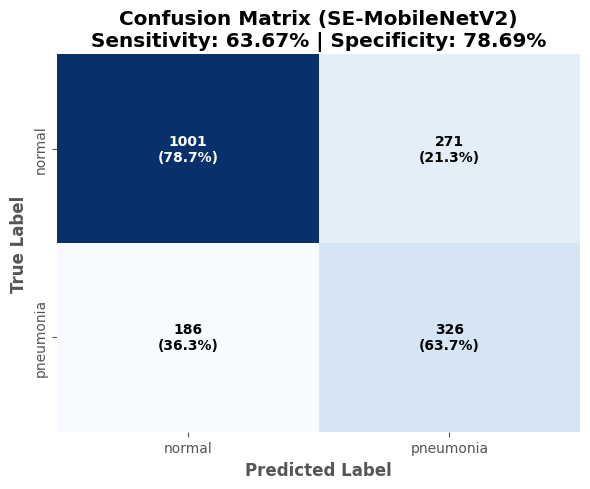

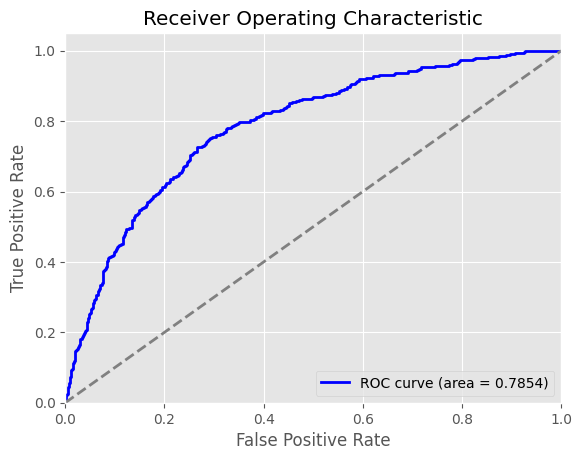

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Function to find the best saved model based on validation loss
def find_best_model(checkpoint_dir):
    best_loss = float('inf')
    best_model_path = None
    for filename in os.listdir(checkpoint_dir):
        if filename.endswith(".keras"):
            parts = filename.split('-')
            try:
                #  The format is se_mobilenetv2_weights-{epoch:03d}-{val_loss:.4f}.keras
                loss = float(parts[-1].split('.')[0]) + float(parts[-1].split('.')[1]) / (10**(len(parts[-1].split('.')[1])))
                if loss < best_loss:
                    best_loss = loss
                    best_model_path = os.path.join(checkpoint_dir, filename)
            except (ValueError, IndexError):
                # Ignore files that don't match the expected naming convention
                continue
    return best_model_path

# Load the best saved model
checkpoint_dir = "/content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-MobileNetV2"
best_model_path = find_best_model(checkpoint_dir)

if best_model_path:
    print(f"Loading best model from: {best_model_path}")
    model = load_model(best_model_path)

    # Evaluate model
    print("\nEvaluating model...")
    test_results = model.evaluate(testGen, batch_size=BATCH_SIZE)
    print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
    print("Test Loss: {:.4f}".format(test_results[0]))

    # Predictions and classification report
    predIdxs = model.predict(testGen)
    predTest = np.argmax(predIdxs, axis=1)

    print("\nClassification Report:")
    print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys(), digits=4))

    # Confusion matrix
    cm = confusion_matrix(testGen.classes, predTest)
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    # Calculate Sensitivity and Specificity
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    print("\nConfusion Matrix:")
    print(cm)
    print("Accuracy: {:.4f}".format(acc))
    print("Sensitivity: {:.4f}".format(sensitivity))
    print("Specificity: {:.4f}".format(specificity))

    # Calculate AUC score
    auc = roc_auc_score(testGen.classes, predIdxs[:, 1])
    print("AUC Score: {:.4f}".format(auc))

    # Plot confusion matrix with class-wise percentages
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=testGen.class_indices.keys(),
                    yticklabels=testGen.class_indices.keys(),
                    cbar=False)

    # Add annotations with counts and class-wise percentages
    for i in range(cm.shape[0]):
        row_sum = cm[i, :].sum()
        for j in range(cm.shape[1]):
            percentage = (cm[i, j] / row_sum) * 100 if row_sum > 0 else 0
            text = f"{cm[i, j]}\n({percentage:.1f}%)"
            # Use white for True Negative (top-left cell), black otherwise
            if i == 0 and j == 0:
                color = 'white'
            else:
                color = 'black'
            ax.text(j + 0.5, i + 0.5, text,
                    ha='center', va='center',
                    color=color,
                    fontweight='bold')

    # Calculate metrics for title
    total = sum(sum(cm))
    acc = (cm[0, 0] + cm[1, 1]) / total
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    plt.title(f"Confusion Matrix (SE-MobileNetV2)\nSensitivity: {sensitivity:.2%} | Specificity: {specificity:.2%}", fontweight='bold')
    plt.xlabel("Predicted Label", fontweight='bold')
    plt.ylabel("True Label", fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(testGen.classes, predIdxs[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

else:
    print(f"No .keras model files found in {checkpoint_dir}")

#### **Model Size**

In [ ]:
import os

# Function to find the best saved model based on validation loss
def find_best_model(checkpoint_dir):
    best_loss = float('inf')
    best_model_path = None
    for filename in os.listdir(checkpoint_dir):
        if filename.endswith(".keras"):
            parts = filename.split('-')
            try:
                # Assuming the format is se_mobilenetv2_weights-{epoch:03d}-{val_loss:.4f}.keras
                loss = float(parts[-1].split('.')[0]) + float(parts[-1].split('.')[1]) / (10**(len(parts[-1].split('.')[1])))
                if loss < best_loss:
                    best_loss = loss
                    best_model_path = os.path.join(checkpoint_dir, filename)
            except (ValueError, IndexError):
                # Ignore files that don't match the expected naming convention
                continue
    return best_model_path

# Load the best saved model
checkpoint_dir = "/content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-MobileNetV2"
best_model_path = find_best_model(checkpoint_dir)

if best_model_path:
    print(f"Best model saved at: {best_model_path}")
    model_size_bytes = os.path.getsize(best_model_path)
    model_size_mb = model_size_bytes / (1024 * 1024)
    print(f"Model size: {model_size_mb:.2f} MB")
else:
    print(f"No .keras model files found in {checkpoint_dir}")

Best model saved at: /content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-MobileNetV2/se_mobilenetv2_weights-025-0.4833.keras
Model size: 15.27 MB
